In [ ]:
Quit[]

# A tutorial to use QuantumManyBody package

This notebook has to be considered as a tutorial, which will explain how to use the QuantumManyBody package to perform numerical computations. The package can be useful to simulate quantum mechanical systems in $1$ dimension; such as spin chain models (having, say, $L$, spin sites) and the so-called SYK model, which is a strongly interacting model of $N$ Majorana fermions, which will be included and discussed in a dedicated section.

First of all, let us load the package:

In [1]:
Needs["QuantumManyBody`"] 

and we will focus first on showing functionalities which can be used to generate spin chain Hamiltonians (although, the vast majority of the functions can be used for Majorana Hamiltonians too). For simplicity, we will consider chains having $10$ sites, which are then associated to Hilbert spaces of dimension $2^10$

In [2]:
latticeSize = 10;
length = 2^latticeSize;

## Creating spin chain Hamiltonians using `SpinChainHamiltonian` and `SpinOperators`

The first function we want to address is the function `SpinChainHamiltonian[listCouplings , listCoefficients]`. Most of the Hamiltonians used in condensed matter are built out of lattices (defined on graphs) in which the spin variables (that here we call $\sigma_i^a$, with $i$ being the site on the graph and $a = x, y, z$ being the orientation of the spin along the $3$ axes) interact through scalar products when they are connected by an edge of the underlying graph.

We will see through some examples, which kind of Hamiltonians can be generated and how.

### The Heisenberg model example

To start with, we will consider probably the simplest yet non-trivial example of Hamiltonian: the Heisenberg chain with periodic boundary conditions. In this model, the spins variables are placed on a necklace like graph;  only the nearest neighbors sites interact among each other, with a constant coupling. In formulas, the Hamiltonian reads

$$
H_\mathrm{Heis} = \sum_{(i , j)} \sum_{a = 1}^3 \, \sigma_i^a \cdot \sigma_j^a \ ,
$$

where the notation $(i, j)$ denotes the nearest neighbors pairs.

To build this hamiltonian, we first create a list, which contains all the nearest neighbors pairs

In [4]:
listCouplings = Partition[Range @ latticeSize , 2 , 1 , 1]

{{1, 2}, {2, 3}, {3, 4}, {4, 5}, {5, 6}, {6, 7}, {7, 8}, {8, 9}, {9, 10}, {10, 1}}

Notice that we are assuming periodic boundary conditions, given the presence of the coupling $\left\{10 , 1\right\}$. We can similarly consider the case with open boundary conditions

In [5]:
listCouplingsOpen = Partition[Range @ latticeSize , 2 , 1]

{{1, 2}, {2, 3}, {3, 4}, {4, 5}, {5, 6}, {6, 7}, {7, 8}, {8, 9}, {9, 10}}

In which we see that the last coupling $\left\{10 , 1\right\}$, which was "closing" the necklace, is now removed. From the formula for the Hamiltonian $H_\mathrm{Heis}$, we see that, for each non trivial coupling $(i, j)$ the three spin operators are coupled  isotropically with strength one. From this we learn that the list of the coefficients, `listCoefficients`, is simply given by 

In [6]:
listCoefficients = ({1 , 1 , 1} &) /@ Range @ Length @ listCouplings;

Given these two ingredients, we are ready to build our Hamiltonian, using `SpinChainHamiltonian`

In [7]:
{hamiltonianHeisenbergDecomposed , hamiltonianHeisenberg} = 
 SpinChainHamiltonian[listCouplings , listCoefficients];

As we see, the output is given by two lists: the first list, here called `hamiltonianHeisenbergDecomposed`, contains all the single terms $\sigma_i^a \cdot \sigma_j^a$, organized as a nested list, in which, for each non-vanishing choice of the site indices $i$ and $j$, the three individual terms with $a = x, y, z$ are separately considered. This list is relevant because each element has the property of being proportional to a unitary operator (in this particular example they are effectively unitary). Hence, `hamiltonianHeisenbergDecomposed` can be useful when we deal with algorithms which make use of a Trotterization of the Hamiltonian (we will see an example  in a later section).
The second list, here called `hamiltonianHeisenberg` denotes instead the full Heisenberg Hamiltonian, $H_\mathrm{Heis}$.

All the resulting matrices are given as `SparseArray`. This is convenient, since the Heisenberg Hamiltonian, as well as most of the Hamiltonians used in condensed matter physics, are very sparse: we can get convinced by this last point using a `MatrixPlot`

-Graphics-
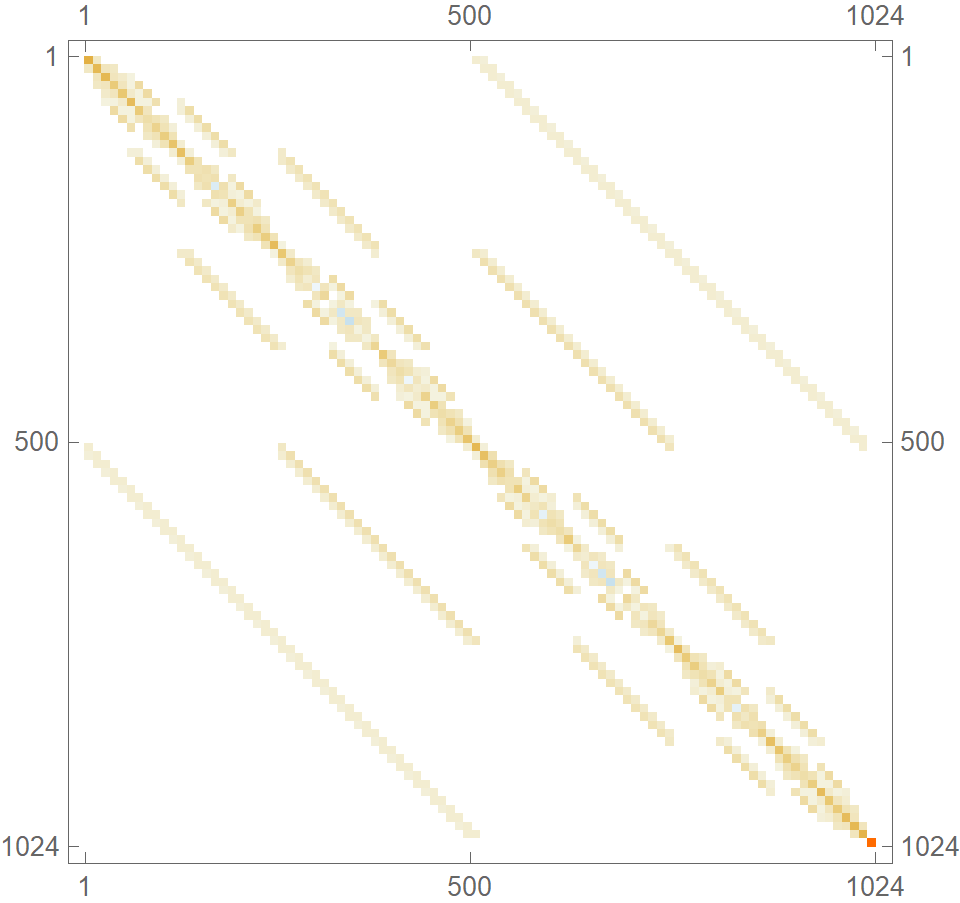

In [8]:
hamiltonianHeisenberg // MatrixPlot

### A more interesting example

Let us now turn to a more interesting example: we will consider an Hamiltonian having both single site terms as well as nearest neighbors and next-to-nearest neighbors couplings. It reads (we are assuming here open boundary conditions)

$$
H = h \, \sum_{i = 1}^L \sigma_i^x - \sum_{i = 1}^{L - 1}J_i \sigma_i^z \cdot \sigma_{i + 1}^z + J_2 \sum_{i = 1}^{L - 2} \sigma_i^z \cdot \sigma_{i + 2}^z \equiv H_0 + H_1 + H_2 \ ,
$$

where the constant $h$ is set to $h = 0.6$,  $J_2$ is set to $J_2 = 0.3$ and the random variables $J_i$ are taken to be $J_i = 1 + \delta J_i$ with the variables $\delta J_i$ extracted randomly from a uniform distribution with support $[-1 , 1]$. 

Let us start by constructing the three terms separately, starting from the easiest, $H_0$:

In [9]:
h = 0.6;
couplingsH0 = {Partition[Range @ latticeSize , 1] , ({h , 0 , 0} &) /@ 
   Range @ latticeSize};

Let us now move to $H_1$

In [11]:
couplingsH1 = {Partition[Range @ latticeSize , 2 , 
   1] , ({0 , 0 , - (1 + RandomReal[{-1 , 1}])} &) /@ 
   Range @ Length @ Partition[Range @ latticeSize , 2 , 1]};

and finally we move to $H_2$

In [12]:
j2 = 0.3; 
couplingsH2 = {({# , # + 2} &) /@ 
   Range[latticeSize - 2] , ({0 , 0 , j2} &) /@ 
   Range @ Length @ Range[latticeSize - 2]};

Now that we have all the terms, we can simply join them

In [14]:
couplingsFullH = 
 Join @@@ Transpose @ {couplingsH0 , couplingsH1 , couplingsH2};

and get the final Hamiltonian (as well as its decomposition in terms of unitaries)

In [15]:
{hamiltonianDecomposed , hamiltonianFull} = 
 SpinChainHamiltonian @@ couplingsFullH;

Let us check that all the decomposed terms are proportional to unitary matrices: as a first step let us check if the product of the elements with their conjugate transpose give diagonal matrices

{{True}, {True}, {True}, {True}, {True}, {True}, {True}, {True}, {True}, {True}, {True}, 
 
>   {True}, {True}, {True}, {True}, {True}, {True}, {True}, {True}, {True}, {True}, 
 
>   {True}, {True}, {True}, {True}, {True}, {True}}
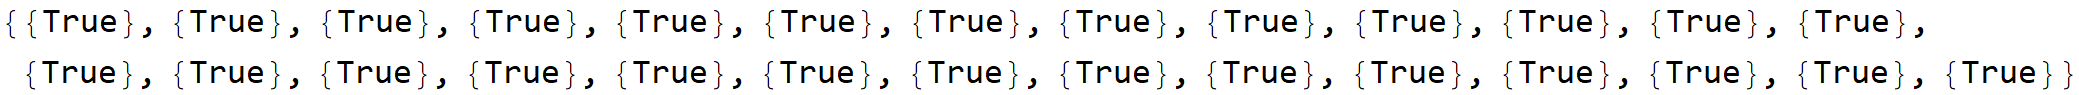

In [16]:
Map[(DiagonalMatrixQ[
    ConjugateTranspose @ # . #]  &), hamiltonianDecomposed , {2}]

the answer is positive, so it just remains to check that the diagonal elements are all equals to each other. To do this, we tally all the elements of the diagonals and check if the resulting list has length equal to one

In [17]:
Map[(Length @ 
    Tally @ Diagonal[
      ConjugateTranspose @ # . #]  &), hamiltonianDecomposed , {2}]

{{1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, 
 
>   {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}, {1}}

We can also visualize the level of sparsity of the full hamiltonian

-Graphics-
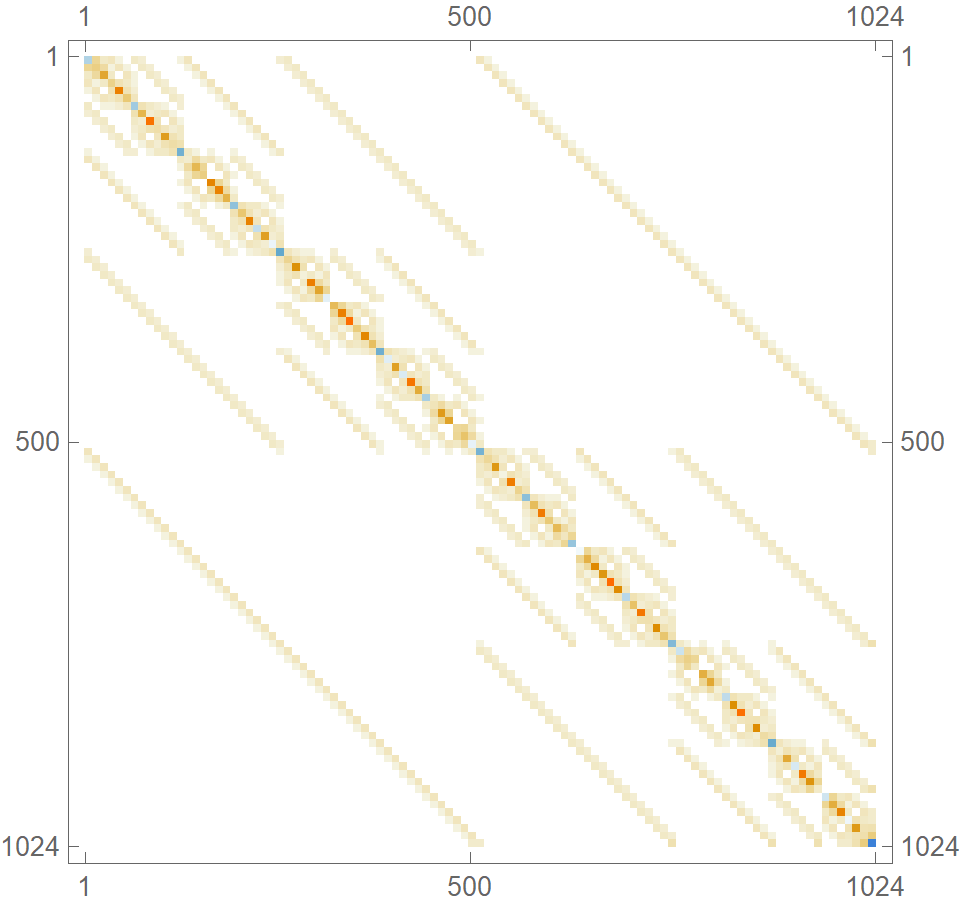

In [18]:
hamiltonianFull // MatrixPlot

### More exotic Hamiltonians: `SpinOperators` function

Whenever one needs to build a more general Hamiltonian, which cannot be built using the function SpinChainHamiltonian or, more generally, if one needs to build explicitly the spin operators, $\sigma_i^a$, the function `SpinOperators[L]` gives the spin operators defined on a spin chain of length `L`. So, for example

In [19]:
sS = SpinOperators[latticeSize];

We see that the spin operators are formatted as a list of lists. Each of the sublists contains the three spin operators defined at a given position in the chain.

## Studying a given Hamiltonian: `FindGroundState`, `EnergyStored` and `FindBandwidth`

Once we have the Hamiltonian, we can now start to study its properties. The first two functions we are going to explore are very simple. As the name suggests, the function `FindGroundState[hamiltonian]` simply computes the ground state (i.e. the state with the lowest energy) associated to a given Hamiltonian.  As an example, let us consider the non-trivial spin-chain Hamiltonian we introduced in the last example and that we recall quickly here

$$
H = h \, \sum_{i = 1}^L \sigma_i^x - \sum_{i = 1}^{L - 1}J_i \sigma_i^z \cdot \sigma_{i + 1}^z + J_2 \sum_{i = 1}^{L - 2} \sigma_i^z \cdot \sigma_{i + 2}^z \equiv H_0 + H_1 + H_2 \ ,
$$

In [20]:
h = 0.6;
j2 = 0.3; 
hamiltonian = 
  SpinChainHamiltonian @@ 
    Join @@@ Transpose @ {{Partition[Range @ latticeSize , 
         1] , ({h , 0 , 0} &) /@ Range @ latticeSize} , {Partition[
         Range @ latticeSize , 2 , 
         1] , ({0 , 0 , - (1 + RandomReal[{-1 , 1}])} &) /@ 
         Range @ Length @ 
           Partition[Range @ latticeSize , 2 , 
            1]} , {({# , # + 2} &) /@ 
         Range[latticeSize - 2] , ({0 , 0 , j2} &) /@ 
         Range @ Length @ Range[latticeSize - 2]}} // Last;

The ground state is then given by

In [23]:
groundState = FindGroundState @ hamiltonian;

and, by making use of the function `EnergyStored[groundState , hamiltonian]` we can compute the associated ground state energy

In [24]:
groundEnergy = EnergyStored[groundState , hamiltonian]

-9.40424

Notice that, more generally, the function `EnergyStored[state , observable]` computes the mean value (in the quantum mechanical sense) of the operator `observable` in the quantum state `state`, i.e. it does not assume that `state` is an eigenstate of `observable`.

Finally, in many applications in condensed matter physics, one needs to compare different Hamiltonians defined at different energy scales. To make meaningful comparisons, it is often useful to compute the bandwidth of a given Hamiltonian, i.e. to compute the energy difference between the energy of the state with maximum energy and the energy of the ground state. The bandwidth of a given hamiltonian is computed by the `function FindBandwidth[hamiltonian]`.

In [25]:
bandwidth = FindBandwidth @ hamiltonian

21.1651

## A quantum algorithm: quantum imaginary time evolution using `QITE`

We now move to describe a quantum computing algorithm: we will approximate the ground state, denoted by $|G\rangle$, of a given Hamiltonian $H$, by using the so called "Quantum imaginary time evolution" algorithm (QITE). The imaginary time evolution (ITE) algorithm, is a well known iterative algorithm to efficiently approximate $|G\rangle$ via an iterative procedure starting from an initial ket, denoted by $|\psi_0\rangle$. The main property of the ITE algorithm is that it always converges to $|G\rangle$, provided that the initial Ansatz $|\psi_0\rangle$ had a non vanishing overlap with it. This is a kind of assumption which is pretty easy to satisfy and that, in particular, does not assume any prior good physical understanding of the physical system under investigation, since it just requires that $\langle G | \psi_0\rangle$ be non-vanishing, a condition which is typically very easy to satisfy.

On the other hand, as we will see the ITE algorithm makes use of non-unitary operators, thus making this algorithm not particularly suitable to be implemented on a quantum computer, especially on a so-called NISQ machine.

In the next section, we will provide a simple introduction to the ITE algorithm and to its quantum version. In the other sections, we will describe how the function `QITE[latticeSize , hamiltonianDecomposed , listCouplings , $\beta$ , $\Delta t$ , initialState , dD , toleranceNumeric :10^-6 , deltaDiagonal : 0.1]` can be used to implement the QITE algorithm on different physical spin chain models.

### The ITE algorithm and its quantum version, a short introduction

In this section we introduce the idea of quantum imaginary time evolution and how it can be modified to make it suitable for a quantum machine. The basic idea is very simple: let us consider an initial state, called $|\psi_0\rangle$. As it is well-known, its time evolution (under the Hamiltonian $H$ which, for simplicity, we assume to be time-independent) is dictated by the Schrödinger equation which, once solved, gives us the time evolved expression for the state

$$
|\psi (t)\rangle \equiv \mathrm{Exp}( - i H t) \, |\psi_0\rangle
$$

Where the expression $\mathrm{Exp}(- i H t)$ refers to the matrix exponential of the operator $- i H t$, defined through its Taylor expansion. We can gain a better intuition of the dynamics by the following observation: we can expand the initial ket, $|\psi_0\rangle$, on the basis defined by the eigenstates of $H$, i.e. on the complete set of states $|E^\alpha\rangle$ satisfying the relations

$$
H \, |E^\alpha\rangle = E^\alpha \, |E^\alpha\rangle
$$

with  $E^0 < E^1 < E^2 \dots$  being the energies of the system (they are real numbers, given that $H$ is Hermitian). The expansion of $|\psi_0\rangle$ on the eigenstates of $H$ reads 

$$
| \psi_0 \rangle = \sum_{\alpha = 0}^{\rm{dim} H - 1} c_0^\alpha |E^\alpha \rangle  
$$

and, in terms of this decomposition, the time evolution can be easily computed explicitly. One simply gets

$$
| \psi (t) \rangle = \sum_{\alpha = 0}^{\rm{dim} H - 1} (c_0^\alpha \, e^{- i E^\alpha t}) |E^\alpha \rangle  
$$

from which we see that, by time evolution, the coefficients $c_0^\alpha$ of the expansion are simply multiplied by the factors $e^{(- i E^\alpha t)}$. The crucial observation is now the following: given that the energies $E^\alpha$ are all real numbers, it follows that the modulus of the various coefficients $c_0^\alpha$ is unchanged by time evolution, i.e.

$$
|c_0^\alpha \, e^{(- i E^\alpha t)}| = |c_0^\alpha| \ .
$$

The situation is completely different if we assume that $t$ is an imaginary, rather than real, number. Let us denote with $\beta$ the real number defined by $\beta \equiv i t$. Under this assumption we get  for the imaginary time evolved state 

$$
| \psi (\beta) \rangle = \sum_{\alpha = 0}^{\rm{dim} H - 1} (c_0^\alpha \, e^{- E^\alpha \beta}) |E^\alpha \rangle  
$$

and, this time, the modulus of the coefficients $c_0^\alpha$ decreases by time evolution

$$
|c_0^\alpha \, e^{(- E^\alpha \beta)}| < |c_0^\alpha| 
$$

and, in particular, we see that the coefficients are more and more suppressed when $\alpha$ increases. Putting the things together we see

$$
| \psi (\beta) \rangle \propto | E^{\mathrm{Min}} \rangle
$$

for large enough values of $\beta$. Here, we denoted with $| E^{\mathrm{min}} \rangle$ the eigenstate of $H$ with the smallest energy, such that the corresponding expansion coefficient, $c_0^\rm{min}$ is non vanishing. In particular, if $c_0^0 \neq 0$, we see that for large enough $\beta$ the imaginary time evolved ket converges to the ground state

$$
| \psi (\beta) \rangle \propto | E^0 \rangle
$$

After this preliminaries, we are now convinced that an efficient method to find the ground state of a given system is to perform the imaginary time evolution

$$
|\psi (\beta)\rangle \equiv \mathrm{Exp}( - H \beta) \, |\psi_0\rangle
$$

for large enough $\beta$. However, we immediate recognize two  problems. The first one is in common to the real time evolution equation

$$
|\psi (t)\rangle \equiv \mathrm{Exp}( - i H t) \, |\psi_0\rangle
$$

and is simply that the unitary operator $\mathrm{Exp}(- i H t)$ is hard to implement with simple circuits. A possible way out to this problem is offered by the so-called Suzuki-Trotter algorithm: suppose, as it is often the case, that our Hamiltonian operator H is $k$-local, i.e., it is given by the sum of terms $h[m]$, each of them acting on $k$ qubits at most

$$
H = \sum_{m = 1}^M h[m]
$$

In such a case, the time evolution operator $\mathrm{Exp}(- i H t)$ can be effectively replaced, up to small errors, by the following expression

$$
|\psi (t)\rangle \sim \bigl(\prod_{m = 1}^M \mathrm{Exp}(- i h[m] \Delta t) \bigr)^n \, |\psi_0 \rangle
$$

with $n = \frac{t}{\Delta t}$ and with an error scaling as $O(\Delta t)$. The main advantage is that the single unitary operators $\mathrm{Exp}(- i h[m] \Delta t)$ are now acting on few qubits and they can be more easily implemented on a quantum computer. Turning to the imaginary time setup, we realize that the ground state can be obtained by the following, imaginary time, Suzuki-Trotter algorithm: 

$$
|\psi (\beta)\rangle \sim \bigl(\prod_{m = 1}^M \mathrm{Exp}(- h[m] \Delta \tau) \bigr)^n \, |\psi_0 \rangle
$$

with $n = \frac{\beta}{\Delta \tau}$. However, we need now to face another difficulty: the operators $\mathrm{Exp}(- h[m] \Delta \tau)$ are not unitary operators, and so they cannot be naturally implemented by a quantum computer.

A way to solve this problem is the following:  the non-unitary, rescaled, operator action

$$
c^{- 1 / 2} \mathrm{Exp}(- h[m] \Delta \tau) \, |\psi \rangle \ , \qquad c \equiv \langle \psi | \mathrm{Exp}(- 2 h[m] \Delta \tau) | \psi \rangle
$$

can be effectively mimicked by a unitary operator action

$$
c^{- 1 / 2} \mathrm{Exp}(- h[m] \Delta \tau) \, |\psi \rangle \sim \mathrm{Exp}(- i A[m] \Delta \tau) \, |\psi \rangle
$$

where the Hermitian operator $A[m]$  acts on a domain which is larger than the domain of  the original operator, $h[m]$. The unitary approximation becomes more and more efficient by increasing the dimension of the domain of $A[m]$ or by reducing the correlation length of $| \psi \rangle$.

The function `QITE[latticeSize , hamiltonianDecomposed , listCouplings , $\beta$ , $\Delta t$ , initialState , dD , toleranceNumeric :10^-6 , deltaDiagonal : 0.1]` performs the QITE algorithm just outlined. It receives as inputs the lattice size of the spin chain, the Suzuki-Trotter decomposition of the Hamiltonian and, in correspondence of this decomposition, it needs also the list of the lattice sites where the single terms, $h[m]$, act. Moreover, it needs to know also the maximum imaginary time to simulate, $\beta$, the single time step, $\Delta \tau$, the initial state, initialState and, finally, how bigger the domain of $A[m]$ should be with respect to the domain of $h[m]$.

In the next section, we will consider an example of usage.

### Finding the ground state using `QITE`: the Heisenberg model example

Let us consider the Heisenberg Hamiltonian. As usual, we first construct the graph of the non vanishing couplings and the corresponding Hamiltonian

In [26]:
listCouplings = Partition[Range @ latticeSize , 2 , 1 , 1];
{hamiltonianDecomposed , hamiltonian} = 
  SpinChainHamiltonian[
   listCouplings , ({1 , 1 , 1} &) /@ Range @ Length @ listCouplings];

and, once again, we compute the ground state and its energy

In [28]:
groundStateHeisenberg = Chop[FindGroundState @ hamiltonian, 10^-8];
groundEnergyHeisenberg = 
 EnergyStored[groundStateHeisenberg , hamiltonian]

-18.0618

We now set the values of $\beta$, $\Delta \tau$ and the initial ket $|\psi_0\rangle$ 

In [30]:
\[Beta] = 3.;
\[CapitalDelta]t = 0.1;
initialState = 
  SparseArray[((Position[#, Min[#]] &) @ 
       Normal @ Diagonal @ hamiltonian)[[1 ]] -> 1. , {2^
    latticeSize} , 0];

Finally,we consider two cases for the domains of $A[m]$, $dD = 0$ which corresponds to the case in which $A[m]$ has the same support of $h[m]$; and $dD = 1$ which corresponds to the case in which the domain of $A[m]$ includes an extra qubits, both at the left and at the right of $h[m]$.

In [33]:
dD = {0 , 1};

we now compute the evolved ket using the QITE algorithm

In [34]:
evolvedKetHeisenberg = 
 Parallelize[(QITE[latticeSize , hamiltonianDecomposed , 
      listCouplings , \[Beta] , \[CapitalDelta]t , 
      initialState , #] &) /@ dD]

{{{0., {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1., 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 
>      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}}, 
 
                                                        -6
>    {0.1, {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.69785 10  , 0, 0.0000135407, 
 
                  -6
>      -2.69775 10  , 0, 0, 0, 0, 0.0000135407, 0, -0.0000679617, 0.0000135402, 0, 0, 
 
                                -6                                     -6
>      0.0000135407, -2.69775 10  , 0, 0, 0, 0, 0, 0, 0, 0, -2.69785 10  , 0, 
 
                                -6                   -6
>      0.0000135407, -2.69775 10  , 0, 0, -2.69785 10  , 0, 0, 0, 0, 0, 0, 0, 0, 0, 

As usual, the evolved ket is given as a list of lists, with each sublists having two elements: the first is the imaginary time, the second is the ket itself.

We can compute the mean energy stored in the evolved ket.

In [35]:
energyHeisenberg = 
  Apply[({#1 , Conjugate @ #2 . hamiltonian . #2} &) , 
   evolvedKetHeisenberg , {2}];

which we plot

Legended[Legended[-Graphics-, Placed[PointLegend[{Directive[PointSize[0.011], 
 
>        RGBColor[0.368417, 0.506779, 0.709798], AbsoluteThickness[1.6]], 
 
>       Directive[PointSize[0.011], RGBColor[0.880722, 0.611041, 0.142051], 
 
>        AbsoluteThickness[1.6]]}, {D = 0, D = 1}, 
 
>      LegendMarkers -> {{False, Automatic}, {False, Automatic}}, 
 
>      Joined -> {True, True}, LabelStyle -> {}, LegendLayout -> Column], After, 
 
>     Identity]], Placed[LineLegend[{Directive[Opacity[1.], AbsoluteThickness[1.6], 
 
>       RGBColor[1, 0, 0]]}, {Exact}, LegendMarkers -> None, LabelStyle -> {}, 
 
>     LegendLayout -> Column], After, Identity]]
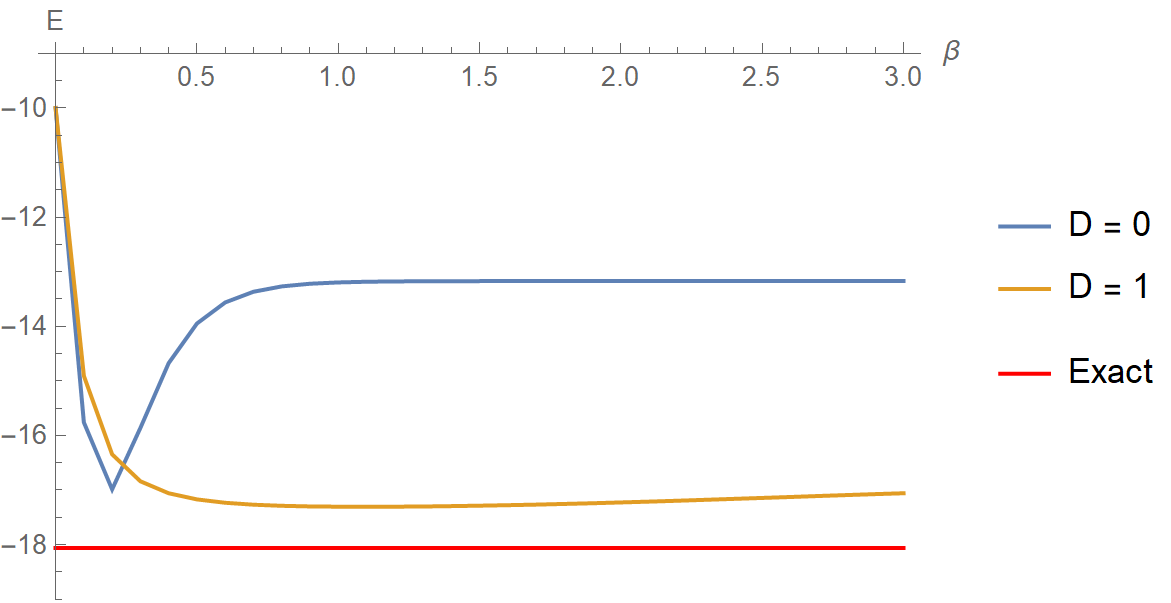

In [36]:
Show[ListPlot[energyHeisenberg , Joined -> True , 
  PlotRange -> {All , {-9 , -19}} , 
  PlotLegends -> {"D = 0" , "D = 1"} , 
  AxesLabel -> {"\[Beta]" , "E"}] , 
 Plot[groundEnergyHeisenberg , {x , 0 , 3} , PlotStyle -> Red , 
  PlotLegends -> {"Exact"} , PlotRange -> All]]

We see that, while at dD = 0 the approximation is not very efficient, things change quite a lot at dD = 1, with a good approximation of the mean energy.